# Models for discriminating SLE patients from nonIMID controls

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import feather
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, plot_roc_curve
from stability_selection import StabilitySelection, plot_stability_path
from joblib import parallel_backend

from sle.regression import coef_from_sm, coef_plot, make_coef_tbl
from sle.modeling import generate_data, prep_data, eval_model, calc_roc_cv, plot_roc_cv
from sle.penalization import regularization_range, choose_C, regularization_path, plot_regularization_path, coef_plots_regularized
%load_ext autoreload
%autoreload 2

/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


If you want to run the code but don't have access to the data, skip the cell below and run the following instead, to generate some synthetic data:

In [2]:
data_dir = os.path.join('..', 'data', 'processed')
data_all = feather.read_dataframe(os.path.join(data_dir, 'imid.feather'))
X_test_df = feather.read_dataframe(os.path.join(data_dir,'rest.feather'))

In [3]:
X_nonIMID, y_nonIMID = prep_data(data_all, 'SLE', 'nonIMID', drop_cols = ["Arthritis","Pleurisy","Pericarditis","Nefritis"])
dsDNA_nonIMID = X_nonIMID.dsDNA2.values.reshape(-1,1) # only dsDNA from chip as a vector
dsDNA_lab_nonIMID = X_nonIMID.dsDNA1.values.reshape(-1,1)
X_nonIMID.drop("dsDNA1", axis=1, inplace=True) # drop clinic dsDNA from multivariable data frame

In [4]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=40)

### Logistic regression: Only dsDNA from microarray

In [5]:
clf = LogisticRegression(penalty = 'none', max_iter = 10000) # increase iterations for solver to converge

In [6]:
lr_dsDNA_nonIMID = clf.fit(dsDNA_nonIMID, y_nonIMID)

In [7]:
np.mean(cross_val_score(clf, dsDNA_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.8006217102395325

Interestingly, AUC for dsDNA only is around the same value as for the vs. blood bank controls, though this is a much harder classification problem. So dsDNA seems to be the most relevant in this set. Also, it's barely lower than the XGBoost model...

**Test on pre-SLE (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.99      0.34      0.51       462
      preSLE       0.05      0.88      0.09        17

    accuracy                           0.36       479
   macro avg       0.52      0.61      0.30       479
weighted avg       0.95      0.36      0.49       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



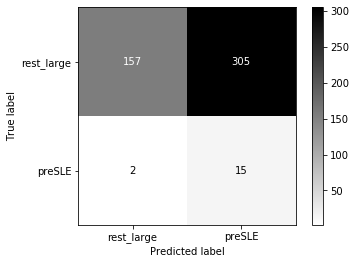

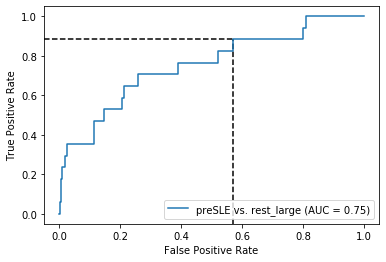

In [8]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large')
eval_model(lr_dsDNA_nonIMID, X_test.dsDNA2.values.reshape(-1,1), y_test, 'preSLE', 'rest_large')

**Test on LLD (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.98      0.34      0.50       462
         LLD       0.08      0.89      0.14        28

    accuracy                           0.37       490
   macro avg       0.53      0.62      0.32       490
weighted avg       0.93      0.37      0.48       490

N.B.: "recall" = sensitivity for the group in this row (e.g. LLD); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. LLD); NPV for the other group (rest_large)



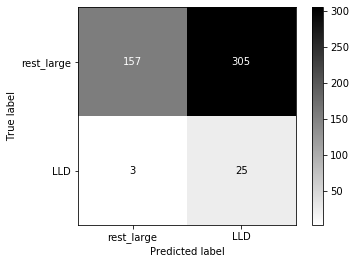

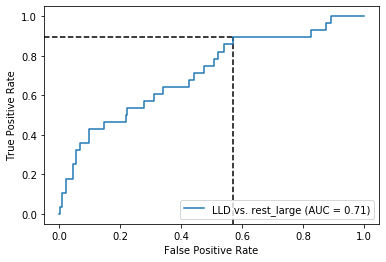

In [9]:
X_test, y_test = prep_data(X_test_df, 'LLD', 'rest_large')
eval_model(lr_dsDNA_nonIMID, X_test.dsDNA2.values.reshape(-1,1), y_test, 'LLD', 'rest_large')

Both for preSLE and LLD, sensitivity is great when only using dsDNA... But specificity is pretty bad

**Test on IMID (vs. blood bank)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

         BBD       0.38      0.13      0.20       361
        IMID       0.46      0.77      0.58       346

    accuracy                           0.45       707
   macro avg       0.42      0.45      0.39       707
weighted avg       0.42      0.45      0.38       707

N.B.: "recall" = sensitivity for the group in this row (e.g. IMID); specificity for the other group (BBD)
N.B.: "precision" = PPV for the group in this row (e.g. IMID); NPV for the other group (BBD)



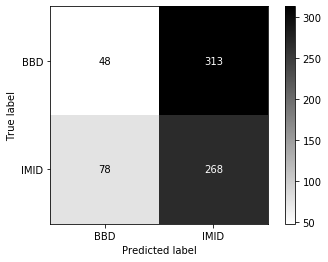

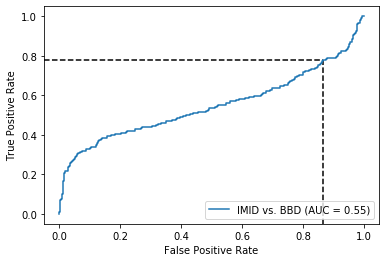

In [10]:
X_test, y_test = prep_data(data_all, 'IMID', 'BBD')
eval_model(lr_dsDNA_nonIMID, X_test.dsDNA2.values.reshape(-1,1), y_test, 'IMID', 'BBD')

Does not do so well even on healthy controls, so this model is just very sensitive to everything it seems

### Logistic regression: Only dsDNA from clinic

In [11]:
clf = LogisticRegression(penalty = 'none', max_iter = 10000) # increase iterations for solver to converge

In [12]:
lr_dsDNA_lab_nonIMID = clf.fit(dsDNA_lab_nonIMID, y_nonIMID)

In [13]:
np.mean(cross_val_score(clf, dsDNA_lab_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.8136558728921921

**Test on pre-SLE (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.00      0.00      0.00       462
      preSLE       0.04      1.00      0.07        17

    accuracy                           0.04       479
   macro avg       0.02      0.50      0.03       479
weighted avg       0.00      0.04      0.00       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


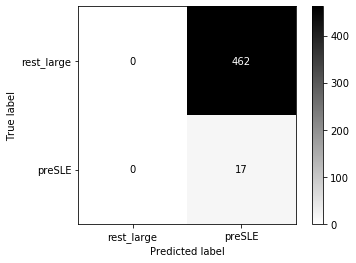

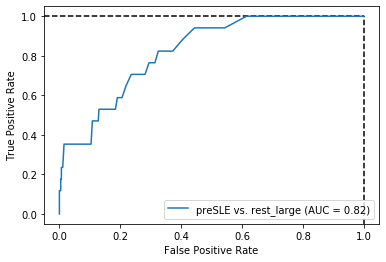

In [14]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large')
eval_model(lr_dsDNA_lab_nonIMID, X_test.dsDNA1.values.reshape(-1,1), y_test, 'preSLE', 'rest_large')

**Test on LLD (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.00      0.00      0.00       462
         LLD       0.06      1.00      0.11        28

    accuracy                           0.06       490
   macro avg       0.03      0.50      0.05       490
weighted avg       0.00      0.06      0.01       490

N.B.: "recall" = sensitivity for the group in this row (e.g. LLD); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. LLD); NPV for the other group (rest_large)



/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


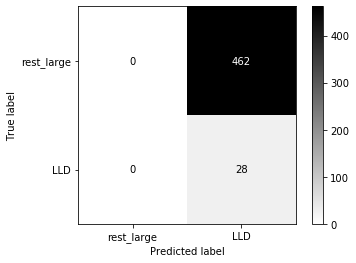

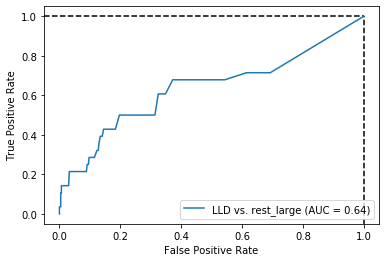

In [15]:
X_test, y_test = prep_data(X_test_df, 'LLD', 'rest_large')
eval_model(lr_dsDNA_lab_nonIMID, X_test.dsDNA1.values.reshape(-1,1), y_test, 'LLD', 'rest_large')

### Logistic regression without dsDNA

In [16]:
no_dsDNA_nonIMID = X_nonIMID.drop(columns='dsDNA2')

In [17]:
np.mean(cross_val_score(clf, no_dsDNA_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.7689850124052804

A model with only dsDNA does better than one with all features but without dsDNA...

### Logistic regression with all features

Scale features to get rid of the skew

In [18]:
Xp1_nonIMID = X_nonIMID + 1 # Some < 0 values > -1. Because negative fluorescence isn't possible, and Box-Cox requires strictly positive values, add ofset

In [19]:
trf = PowerTransformer(method='box-cox')
pipe_trf = Pipeline([
        ('transform', trf),
        ('clf', clf)])

In [20]:
np.mean(cross_val_score(pipe_trf, Xp1_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.8337294463757692

In [21]:
X_trf_nonIMID = pd.DataFrame(trf.fit_transform(Xp1_nonIMID), index=X_nonIMID.index, columns=X_nonIMID.columns)

In [22]:
logreg_trf_nonIMID = sm.Logit(y_nonIMID,sm.add_constant(X_trf_nonIMID)).fit()

Optimization terminated successfully.
         Current function value: 0.370490
         Iterations 8


In [23]:
logreg_trf_nonIMID.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  701
Model:                          Logit   Df Residuals:                      643
Method:                           MLE   Df Model:                           57
Date:                Mon, 09 May 2022   Pseudo R-squ.:                  0.4023
Time:                        13:24:11   Log-Likelihood:                -259.71
converged:                       True   LL-Null:                       -434.54
Covariance Type:            nonrobust   LLR p-value:                 1.150e-43
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.7953      0.176     10.213      0.000       1.451       2.140
Actinin         -0.0771      0.149     -0.518      0.604      -0.369       0.214
ASCA            -0.2462      0.140     -1.763      0.078      -0.520       0.027
Beta2GP1        -0.2659      0.129     -2.057      0.040      -0.519      -0.013
C1q             -0.0068      0.152     -0.045      0.964      -0.305       0.291
C3b              0.1107      0.183      0.605      0.545      -0.248       0.469
Cardiolipin     -0.1269      0.134     -0.949      0.343      -0.389       0.135
CCP1arg         -0.0193      0.176     -0.110      0.912      -0.363       0.325
CCP1cit          0.4228      0.206      2.049      0.040       0.018       0.827
CENP            -0.1206      0.134     -0.903      0.367      -0.382       0.141
CMV              0.0332      0.141      0.236      0.813      -0.243       0.309
CollagenII       0.1021      0.165      0.620      0.535      -0.221       0.425
CpGmot           0.6923      0.252      2.751      0.006       0.199       1.185
CRP1             0.1281      0.175      0.732      0.464      -0.215       0.471
DFS70           -0.0569      0.137     -0.416      0.677      -0.325       0.211
dsDNA2           1.4226      0.226      6.284      0.000       0.979       1.866
Enolasearg      -0.2186      0.176     -1.238      0.216      -0.565       0.127
Enolasecit      -0.2687      0.200     -1.344      0.179      -0.661       0.123
EphB2           -0.5244      0.187     -2.806      0.005      -0.891      -0.158
FcER            -0.4159      0.143     -2.900      0.004      -0.697      -0.135
Fibrillarin     -0.2297      0.142     -1.619      0.105      -0.508       0.048
Ficolin         -0.0528      0.164     -0.323      0.747      -0.373       0.268
GAPDH           -0.2759      0.161     -1.710      0.087      -0.592       0.040
GBM             -0.2263      0.147     -1.540      0.123      -0.514       0.062
H2Bp             0.3658      0.206      1.774      0.076      -0.038       0.770
H2Bpac          -0.3061      0.211     -1.454      0.146      -0.719       0.107
H4p             -0.2371      0.167     -1.424      0.155      -0.564       0.089
H4pac            0.3143      0.169      1.854      0.064      -0.018       0.646
Histones         0.5177      0.196      2.635      0.008       0.133       0.903
IFNLambda       -0.1335      0.143     -0.935      0.350      -0.413       0.146
IFNOmega        -0.1391      0.137     -1.018      0.308      -0.407       0.129
Jo1             -0.1020      0.145     -0.705      0.481      -0.385       0.181
Ku               0.0382      0.150      0.255      0.799      -0.255       0.331
LaSSB            0.1743      0.173      1.009      0.313      -0.164       0.513
MBL2             0.1371      0.144      0.954      0.340      -0.145       0.419
Mi2             -0.3063      0.149     -2.050      0.040      -0.599      -0.014
Nucleosome       0.0451      0.221      0.204      0.838      -0.387       0.477
P

In [24]:
coefs_trf_nonIMID = coef_from_sm(logreg_trf_nonIMID)

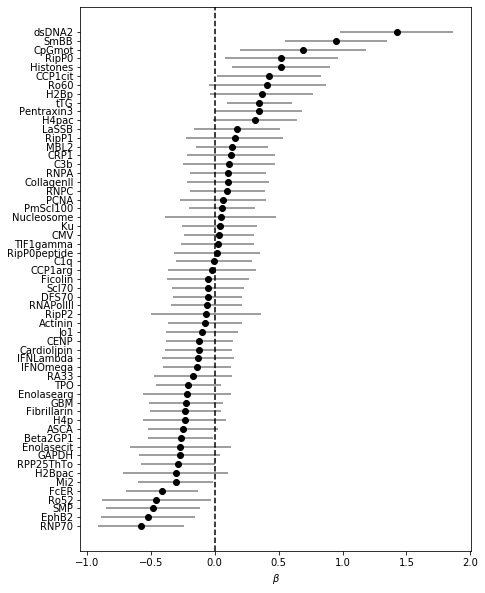

In [25]:
coef_plot(coefs_trf_nonIMID, OR=False)

In contrast to blood bank controls, there's no quasi-complete separation in this model. CIs are wider and less predictors are significant. dsDNA and anti-Smith lead, which is to be expected. CpGmot also significant here. Ro60 quite a bit lower in the rank, and anti-correlated to Ro52...

### Penalized logistic regression

#### Ridge

In [26]:
clf_ridge = LogisticRegression(penalty='l2', max_iter = 10000)

In [27]:
K = 100
lambda_min, lambda_max = regularization_range(Xp1_nonIMID,y_nonIMID,trf,alpha=1e-2, epsilon=1e-6)
Cs_ridge_nonIMID = np.logspace(np.log10(1/lambda_min), np.log10(1/lambda_max), K) # C is inverse of lambda
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_ridge)
])
params = [{
    "clf__C": Cs_ridge_nonIMID
}]

ridge_nonIMID = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [28]:
%%time
ridge_nonIMID.fit(Xp1_nonIMID,y_nonIMID)

CPU times: user 8min 37s, sys: 11min 49s, total: 20min 27s
Wall time: 6min 28s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000))]),
             param_grid=[{'clf__C': array([6.52012573e+01, 5.67087285e+01, 4.93223600e+01, 4.28980735e+01,
       3.73105566e+01, 3.24508194e+01, 2.82240678e+01, 2.45478548e+01,
       2.13504...
       9.24210976e-04, 8.03831574e-04, 6.99131710e-04, 6.08069108e-04,
       5.28867500e-04, 4.59981980e-04, 4.00068869e-04, 3.47959500e-04,
       3.02637428e-04, 2.63218601e-04, 2.28934116e-04, 1.99115219e-04,
       1.73180263e-04, 1.50623361e-04, 1.31004518e-04, 1.13941049e-04,
       9.91001136e-05, 8.61922249e-05, 7.49656017e-05, 6.52012573e-05])}],
             refit=<function choose_C at 0x7f7c2b3249e0>, scoring='roc_auc')

Best model:

In [29]:
ridge_nonIMID.cv_results_['mean_test_score'].max()

0.8381251384923316

Score with lambda selected through 1 SE rule:

In [30]:
ridge_nonIMID.cv_results_['mean_test_score'][ridge_nonIMID.best_index_]

0.8333156017741549

In [31]:
coefs_ridge_nonIMID, nnz_coefs_ridge_nonIMID = regularization_path(Cs_ridge_nonIMID, clf_ridge, X_trf_nonIMID, y_nonIMID)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7c207dc690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7c20789610>)

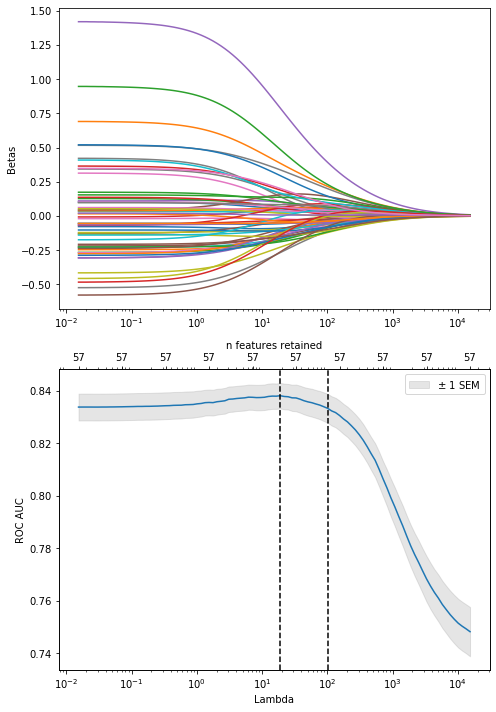

In [32]:
plot_regularization_path(1/Cs_ridge_nonIMID, coefs_ridge_nonIMID, nnz_coefs_ridge_nonIMID, ridge_nonIMID.cv_results_)

#### LASSO

In [33]:
clf_lasso = LogisticRegression(penalty='l1', max_iter = 10000, solver = 'liblinear')

In [34]:
K = 100
lambda_min, lambda_max = regularization_range(Xp1_nonIMID,y_nonIMID,trf)
Cs_lasso_nonIMID = np.logspace(np.log10(1/lambda_min),np.log10(1/lambda_max), K)
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_lasso)
])
params = [{
    "clf__C": Cs_lasso_nonIMID
}]

lasso_nonIMID = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [35]:
%%time
lasso_nonIMID.fit(Xp1_nonIMID,y_nonIMID)

CPU times: user 4min 47s, sys: 0 ns, total: 4min 47s
Wall time: 4min 47s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid=[{'clf__C': array([6.52012573, 6.08069108, 5.67087285, 5.288675  , 4.932236  ,
       4.5998198 , 4.28980735, 4.00068869, 3.73105566, 3...
       0.04932236, 0.0459982 , 0.04289807, 0.04000689, 0.03731056,
       0.03479595, 0.03245082, 0.03026374, 0.02822407, 0.02632186,
       0.02454785, 0.02289341, 0.02135047, 0.01991152, 0.01856955,
       0.01731803, 0.01615085, 0.01506234, 0.01404719, 0.01310045,
       0.01221753, 0.0113941 , 0.01062618, 0.00991001, 0.00924211,
       0.00861922

Best model:

In [36]:
lasso_nonIMID.cv_results_['mean_test_score'].max()

0.8373836641710802

Score with lambda selected through 1 SE rule:

In [37]:
lasso_nonIMID.cv_results_['mean_test_score'][lasso_nonIMID.best_index_]

0.833423534978168

Here LASSO is no longer better than Ridge

In [38]:
coefs_lasso_nonIMID, nnz_coefs_lasso_nonIMID = regularization_path(Cs_lasso_nonIMID, clf_lasso, X_trf_nonIMID, y_nonIMID)

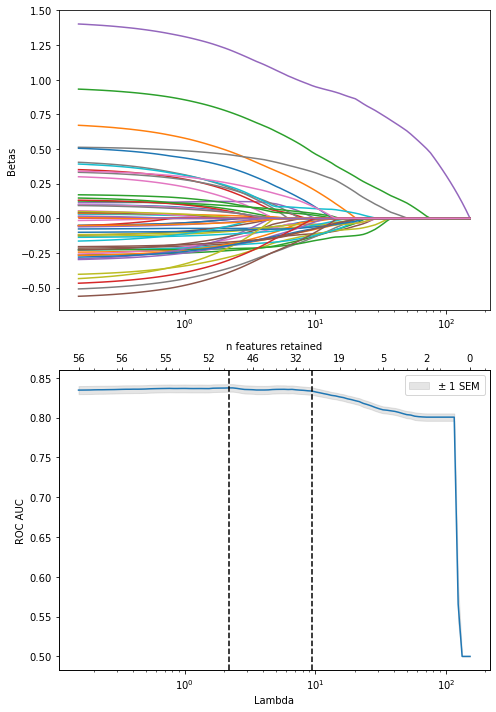

In [39]:
ax1, ax2, ax22 = plot_regularization_path(1/Cs_lasso_nonIMID, coefs_lasso_nonIMID, nnz_coefs_lasso_nonIMID, lasso_nonIMID.cv_results_)
#ax22.set_ylim([0.8, 1])

So best performance retains almost all features, but performance only drops less than .05 AUC with dramatically less features

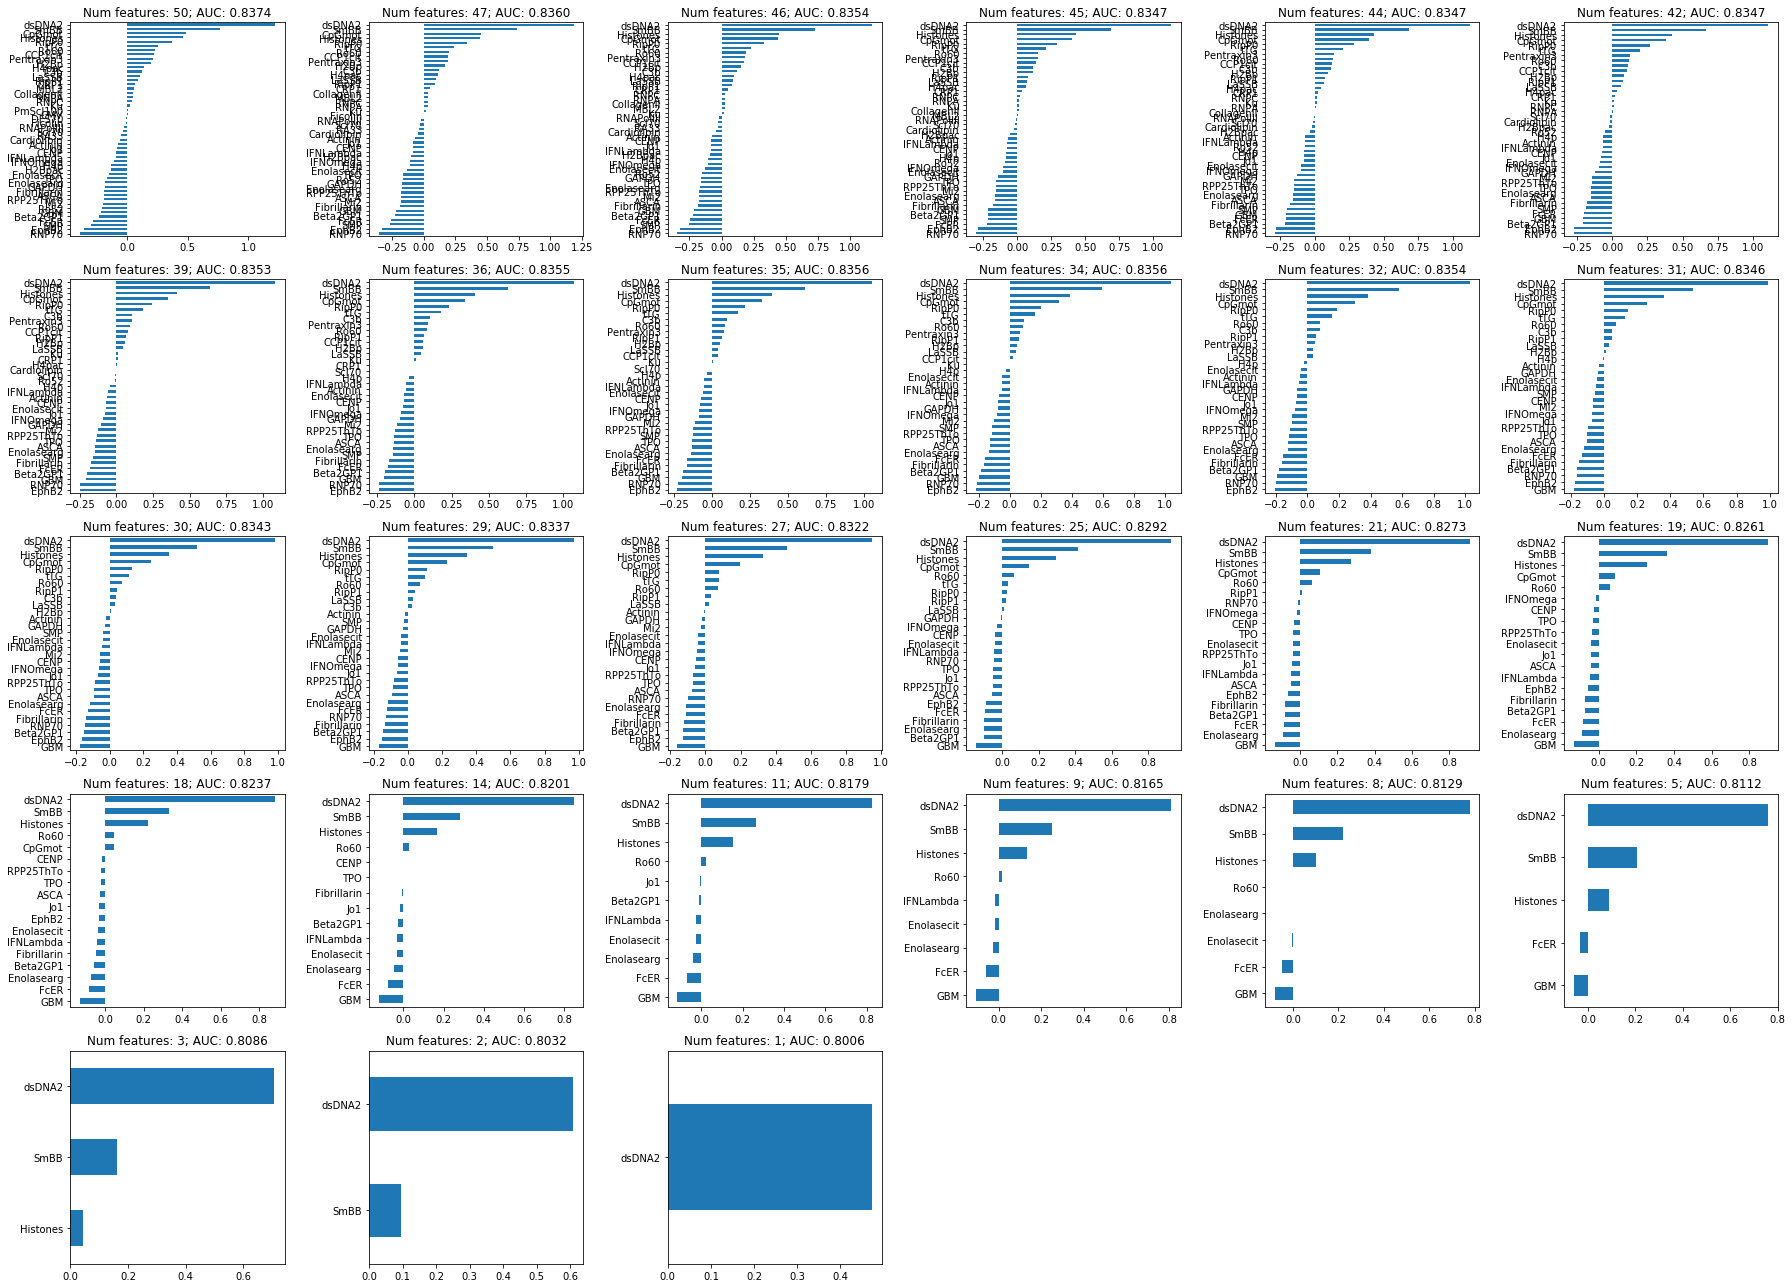

In [40]:
coef_plots_regularized(coefs_lasso_nonIMID, nnz_coefs_lasso_nonIMID, lasso_nonIMID.cv_results_["mean_test_score"], varnames=X_nonIMID.columns, num_subplot_cols=6)

So again, dsDNA is really the dominant feature here. But, to maximize performance, it might be best to regularize until about half of the original features are included, as performance starts to decline monotonically from that point forwards

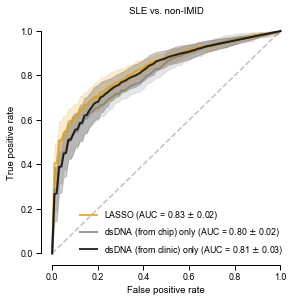

In [41]:
with sns.plotting_context("paper"):
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams['pdf.fonttype'] = 42 # this causes the pdf to be editable, but it also embeds the font, significantly increasing the size
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    tprs, aucs = calc_roc_cv(lasso_nonIMID.best_estimator_,cv,Xp1_nonIMID,y_nonIMID)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, fig_title='SLE vs. non-IMID', line_color='#E69F00', legend_label='LASSO')
    tprs, aucs = calc_roc_cv(lr_dsDNA_nonIMID,cv,dsDNA_nonIMID,y_nonIMID)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, reuse=True, line_color='gray', legend_label='dsDNA (from chip) only')
    tprs, aucs = calc_roc_cv(lr_dsDNA_lab_nonIMID,cv,dsDNA_lab_nonIMID,y_nonIMID)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, reuse=True, line_color='black', legend_label='dsDNA (from clinic) only')
    sns.despine(fig=fig,ax=ax, trim=True)
    plt.legend(frameon=False)
    plt.show()
    fig.savefig('roc_SLE_nonIMID.png', bbox_inches='tight', dpi=300, transparent=True)
    fig.savefig('roc_SLE_nonIMID.pdf', bbox_inches='tight', transparent=True)

Non-zero coefficients of the model selected with the 1SE rule:

In [42]:
coefs_final_nonimid = (pd.Series(lasso_nonIMID.best_estimator_.named_steps.clf.coef_.squeeze(), 
                                 index = X_nonIMID.columns)[lambda x: x!=0].sort_values())
coefs_final_nonimid

GBM           -0.164424
EphB2         -0.141745
Beta2GP1      -0.135576
Fibrillarin   -0.127466
FcER          -0.117419
RNP70         -0.114466
Enolasearg    -0.112280
ASCA          -0.084297
TPO           -0.079599
RPP25ThTo     -0.076756
Jo1           -0.063222
CENP          -0.055635
IFNOmega      -0.052297
IFNLambda     -0.043295
Enolasecit    -0.042869
Mi2           -0.033627
GAPDH         -0.023148
Actinin       -0.013356
SMP           -0.007426
C3b            0.009626
LaSSB          0.025109
RipP1          0.037874
Ro60           0.071421
tTG            0.089406
RipP0          0.097295
CpGmot         0.215477
Histones       0.336896
SmBB           0.479428
dsDNA2         0.958141
dtype: float64

In [43]:
len(coefs_final_nonimid)

29

In [44]:
make_coef_tbl(logreg_trf_nonIMID, lasso_nonIMID.best_estimator_.named_steps.clf, X_nonIMID.columns)

,coef_regularized,coef,std err,95%CI
const,1.101,1.795,0.176,"1.451, 2.14"
Actinin,-0.013,-0.077,0.149,"-0.369, 0.214"
ASCA,-0.084,-0.246,0.140,"-0.52, 0.027"
Beta2GP1,-0.136,-0.266,0.129,"-0.519, -0.013"
C1q,0.000,-0.007,0.152,"-0.305, 0.291"
C3b,0.010,0.111,0.183,"-0.248, 0.469"
Cardiolipin,0.000,-0.127,0.134,"-0.389, 0.135"
CCP1arg,0.000,-0.019,0.176,"-0.363, 0.325"
CCP1cit,0.000,0.423,0.206,"0.018, 0.827"
CENP,-0.056,-0.121,0.134,"-0.382, 0.141"


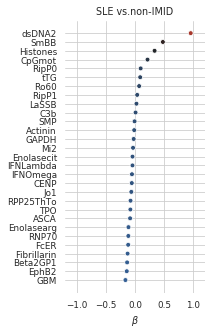

In [45]:
pal = sns.diverging_palette(250, 15, s=75, l=40, center="dark", as_cmap=True)
with sns.plotting_context("paper"):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(2.5, 5))
        g = sns.scatterplot(y=coefs_final_nonimid.index, x=coefs_final_nonimid.values, 
                            hue=coefs_final_nonimid.values, palette=pal, legend=False)
        ax.set(title='SLE vs.non-IMID',
               xticks=np.linspace(-1.0,1.0,5), xlim=[-1.2,1.2], xlabel=r'$\beta$')
        sns.despine(fig=fig,ax=ax, left=True, bottom=True)
        #fig.savefig('coefs_SLE_nonIMID.png', bbox_inches='tight', dpi=300, transparent=True)
        #fig.savefig('coefs_SLE_nonIMID.pdf', bbox_inches='tight', transparent=True)

In contrast to the blood bank controls, refitting with the chosen lambda to the whole dataset here seems to include much more features than during CV: 29 vs < 20. Might suggest that the included features are less stable. So let's examine stability selection again:

In [46]:
%%time
selector_nonIMID = StabilitySelection(base_estimator=pipe, lambda_name='clf__C',
                                  lambda_grid=Cs_lasso_nonIMID[np.argmax(lasso_nonIMID.cv_results_["mean_test_score"]):],
                                  random_state=40) # range from lambda with highest score to lambda_max
selector_nonIMID.fit(Xp1_nonIMID, y_nonIMID)

CPU times: user 9min 4s, sys: 0 ns, total: 9min 4s
Wall time: 9min 7s


StabilitySelection(base_estimator=Pipeline(steps=[('trf',
                                                   PowerTransformer(method='box-cox')),
                                                  ('clf',
                                                   LogisticRegression(max_iter=10000,
                                                                      penalty='l1',
                                                                      solver='liblinear'))]),
                   lambda_grid=array([0.45998198, 0.42898073, 0.40006887, 0.37310557, 0.3479595 ,
       0.32450819, 0.30263743, 0.28224068, 0.2632186 , 0.24547855,
       0.22893412, 0.21350472, 0.19911522, 0.18569552, 0.1731802...
       0.05670873, 0.05288675, 0.04932236, 0.0459982 , 0.04289807,
       0.04000689, 0.03731056, 0.03479595, 0.03245082, 0.03026374,
       0.02822407, 0.02632186, 0.02454785, 0.02289341, 0.02135047,
       0.01991152, 0.01856955, 0.01731803, 0.01615085, 0.01506234,
       0.01404719, 0.01310045, 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7c392aae90>)

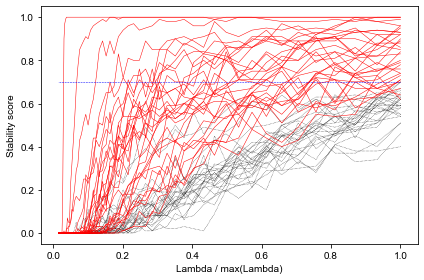

In [47]:
thresh = .70
plot_stability_path(selector_nonIMID, threshold_highlight=thresh)

In [48]:
selector_nonIMID.set_params(threshold=thresh)
selected_variables = selector_nonIMID.get_support(indices=True)
selected_scores = selector_nonIMID.stability_scores_.max(axis=1)

pd.DataFrame({'Variable': Xp1_nonIMID.columns[selected_variables], 
              'Stability score': selected_scores[selected_variables]}).sort_values(by='Stability score', ascending=False)

,Variable,Stability score
27,SmBB,1.00
6,dsDNA2,1.00
16,Histones,1.00
24,RNP70,1.00
5,CpGmot,0.99
2,Beta2GP1,0.97
13,GBM,0.96
9,EphB2,0.95
10,FcER,0.94
11,Fibrillarin,0.94


Many of these seem to be selected as well by the 1SE LASSO model, but not all. For instance, the two variables with the lowest (positive) coefficients (`RipP1`, `LaSSB`) are missing here. At least in the case of `RipP1`, that might be because it's highly correlated with other variables. When LASSO selects one of these, `RipP1`  will not be, driving down its inclusion probability.

All variables with a stability score of > .80 are included in the 1SE LASSO model, but below there are some differences

**Test on pre-SLE (vs. rest) group**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.99      0.51      0.67       462
      preSLE       0.06      0.88      0.12        17

    accuracy                           0.52       479
   macro avg       0.53      0.70      0.39       479
weighted avg       0.96      0.52      0.65       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



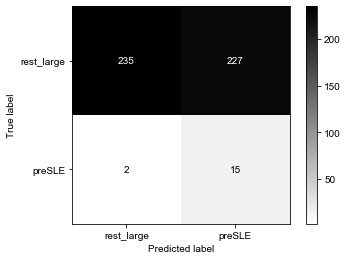

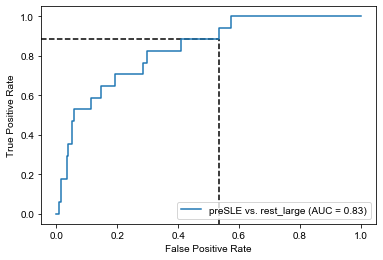

In [49]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large')

Sensitivity is the same as when only using dsDNA, but specificity did improve quite a bit

**Figure 3**:

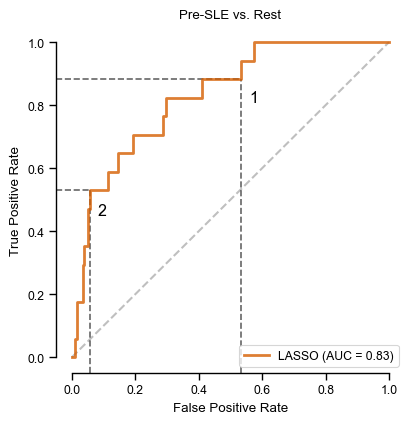

In [50]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
# ROC curve
threshold1=0.5
threshold2=0.84
fpr, tpr, thresholds = roc_curve(y_test, lasso_nonIMID.predict_proba(X_test+1)[:,1])
thr_idx1 = (np.abs(thresholds - threshold1)).argmin() # find index of value closest to chosen threshold
thr_idx2 = (np.abs(thresholds - threshold2)).argmin() # find index of value closest to chosen threshold
sns.reset_defaults()
with sns.plotting_context("paper"):
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams['pdf.fonttype'] = 42 # this causes the pdf to be editable, but it also embeds the font, significantly increasing the size
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', alpha=.25)
    ax.set(title="Pre-SLE vs. Rest",
           xlim=[-0.05, 1.05], xlabel='False positive rate', 
           ylim=[-0.05, 1.05], ylabel='True positive rate')
    ymin, ymax = ax.get_ylim(); xmin, xmax = ax.get_xlim()
    plt.vlines(x=fpr[thr_idx1], ymin=ymin, ymax=tpr[thr_idx1], color='k', alpha=.6, linestyle='--', axes=ax) # plot line for fpr at threshold
    plt.hlines(y=tpr[thr_idx1], xmin=xmin, xmax=fpr[thr_idx1], color='k', alpha=.6, linestyle='--', axes=ax) # plot line for tpr at threshold
    plt.vlines(x=fpr[thr_idx2], ymin=ymin, ymax=tpr[thr_idx2], color='k', alpha=.6, linestyle='--', axes=ax) # plot line for fpr at threshold
    plt.hlines(y=tpr[thr_idx2], xmin=xmin, xmax=fpr[thr_idx2], color='k', alpha=.6,  linestyle='--', axes=ax) # plot line for tpr at threshold
    plot_roc_curve(lasso_nonIMID, X_test+1, y_test, name = "LASSO", ax=ax, color='#D55E00', lw=2, alpha=.8)
    plt.text(0.56,0.81, '1', fontsize='large')
    plt.text(0.08,0.45, '2', fontsize='large')
    sns.despine(fig=fig,ax=ax, trim=True)
    fig.savefig('roc_pre-SLE_Rest.png', bbox_inches='tight', dpi=300, transparent=True)
    fig.savefig('roc_pre-SLE_Rest.pdf', bbox_inches='tight', transparent=True)

Threshold for classification: 0.6
              precision    recall  f1-score   support

  rest_large       0.99      0.67      0.80       462
      preSLE       0.08      0.82      0.15        17

    accuracy                           0.67       479
   macro avg       0.54      0.75      0.48       479
weighted avg       0.96      0.67      0.78       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



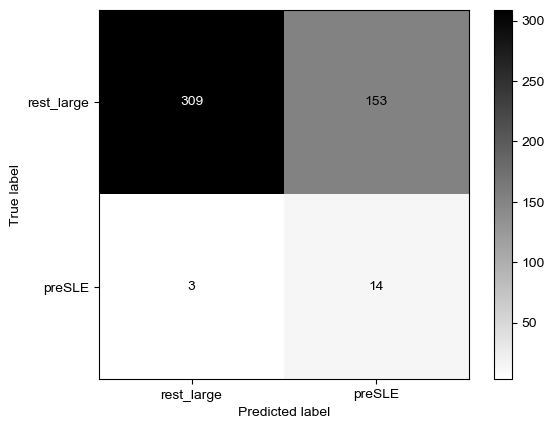

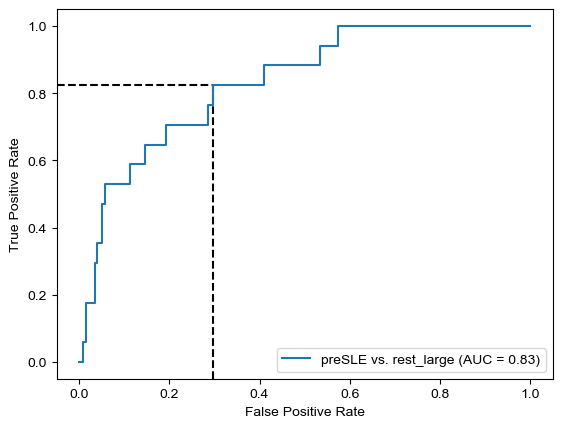

In [51]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"]  + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large', threshold=0.6)

Threshold for classification: 0.7
              precision    recall  f1-score   support

  rest_large       0.99      0.81      0.89       462
      preSLE       0.12      0.71      0.20        17

    accuracy                           0.80       479
   macro avg       0.55      0.76      0.54       479
weighted avg       0.96      0.80      0.86       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



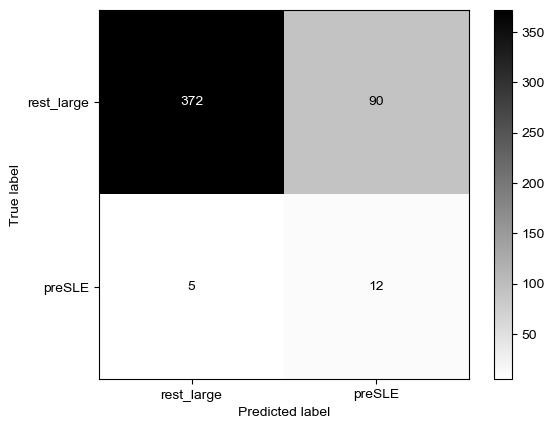

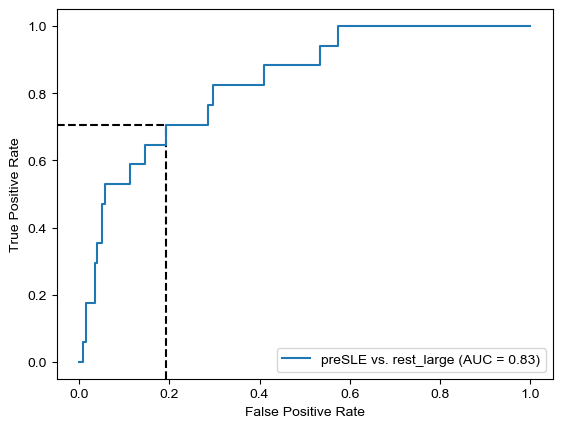

In [52]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large', threshold=0.7)

Threshold for classification: 0.8
              precision    recall  f1-score   support

  rest_large       0.98      0.91      0.95       462
      preSLE       0.18      0.53      0.27        17

    accuracy                           0.90       479
   macro avg       0.58      0.72      0.61       479
weighted avg       0.95      0.90      0.92       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



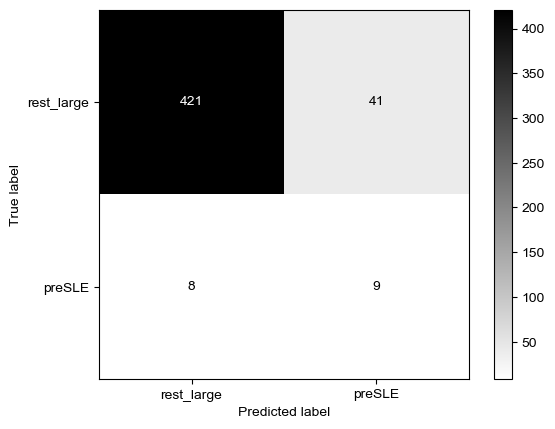

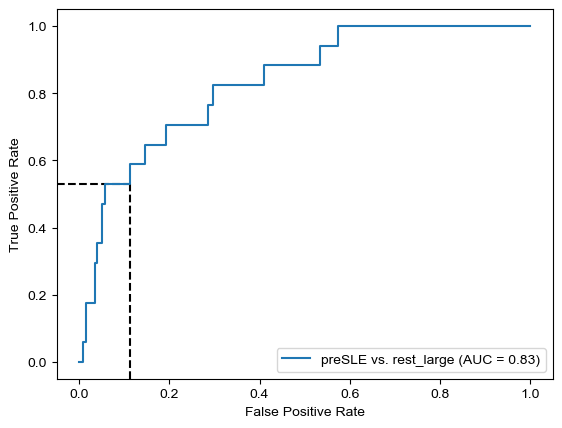

In [53]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large', threshold=0.8)

Threshold for classification: 0.84
              precision    recall  f1-score   support

  rest_large       0.98      0.94      0.96       462
      preSLE       0.25      0.53      0.34        17

    accuracy                           0.93       479
   macro avg       0.62      0.74      0.65       479
weighted avg       0.96      0.93      0.94       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



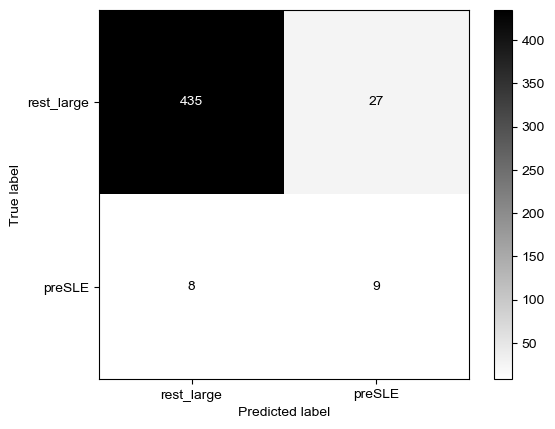

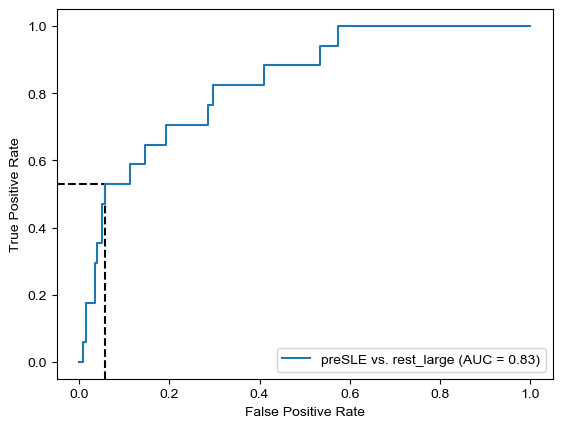

In [54]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large', threshold=0.84)

**Test on LLD (vs. rest)**

*Default threshold:*

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.97      0.51      0.67       462
         LLD       0.08      0.71      0.15        28

    accuracy                           0.52       490
   macro avg       0.52      0.61      0.41       490
weighted avg       0.92      0.52      0.64       490

N.B.: "recall" = sensitivity for the group in this row (e.g. LLD); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. LLD); NPV for the other group (rest_large)



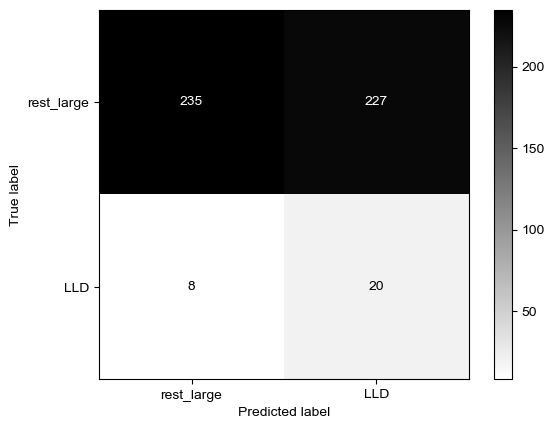

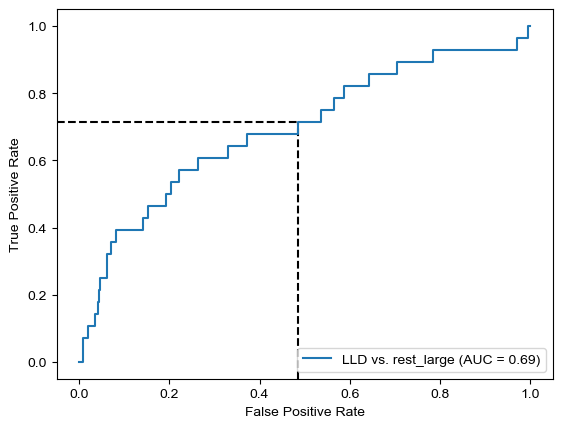

In [55]:
X_test, y_test = prep_data(X_test_df, 'LLD', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'LLD', 'rest_large')

Sensitivity was actually better for dsDNA only... But again, specificity here is much higher

*Threshold for high specificity:*

Threshold for classification: 0.84
              precision    recall  f1-score   support

  rest_large       0.95      0.94      0.95       462
         LLD       0.21      0.25      0.23        28

    accuracy                           0.90       490
   macro avg       0.58      0.60      0.59       490
weighted avg       0.91      0.90      0.91       490

N.B.: "recall" = sensitivity for the group in this row (e.g. LLD); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. LLD); NPV for the other group (rest_large)



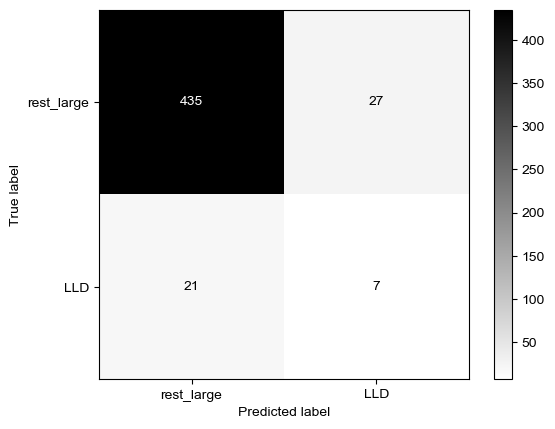

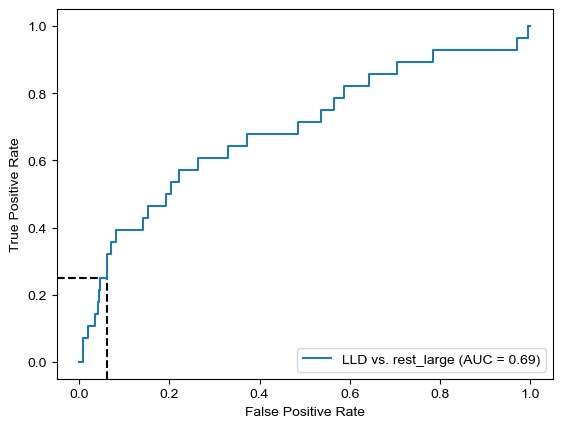

In [56]:
X_test, y_test = prep_data(X_test_df, 'LLD', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'LLD', 'rest_large', threshold = 0.84)

**Test on IMID (vs. blood bank)**

*Default threshold:*

Threshold for classification: 0.5
              precision    recall  f1-score   support

         BBD       0.62      0.58      0.60       361
        IMID       0.59      0.63      0.61       346

    accuracy                           0.60       707
   macro avg       0.60      0.60      0.60       707
weighted avg       0.60      0.60      0.60       707

N.B.: "recall" = sensitivity for the group in this row (e.g. IMID); specificity for the other group (BBD)
N.B.: "precision" = PPV for the group in this row (e.g. IMID); NPV for the other group (BBD)



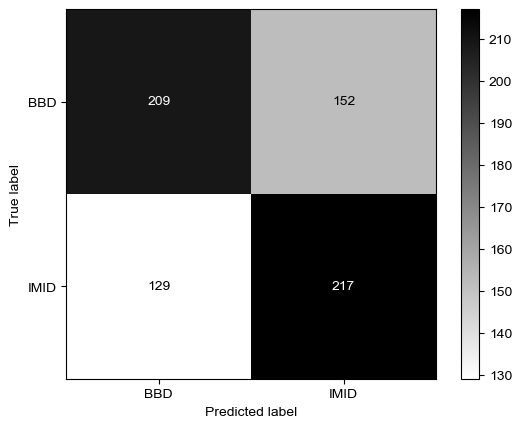

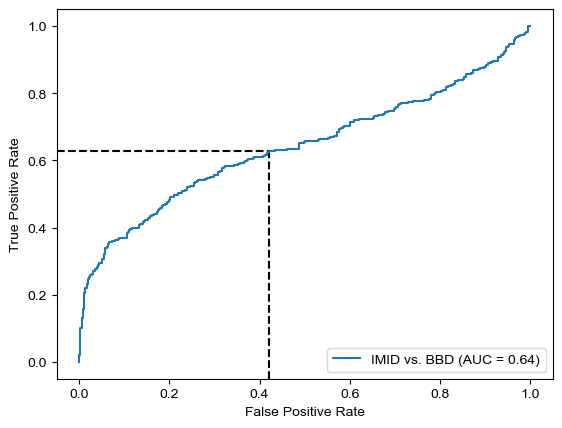

In [57]:
X_test, y_test = prep_data(data_all, 'IMID', 'BBD', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'IMID', 'BBD')

*Threshold for high specificity:*

Threshold for classification: 0.84
              precision    recall  f1-score   support

         BBD       0.54      0.99      0.70       361
        IMID       0.96      0.13      0.23       346

    accuracy                           0.57       707
   macro avg       0.75      0.56      0.47       707
weighted avg       0.75      0.57      0.47       707

N.B.: "recall" = sensitivity for the group in this row (e.g. IMID); specificity for the other group (BBD)
N.B.: "precision" = PPV for the group in this row (e.g. IMID); NPV for the other group (BBD)



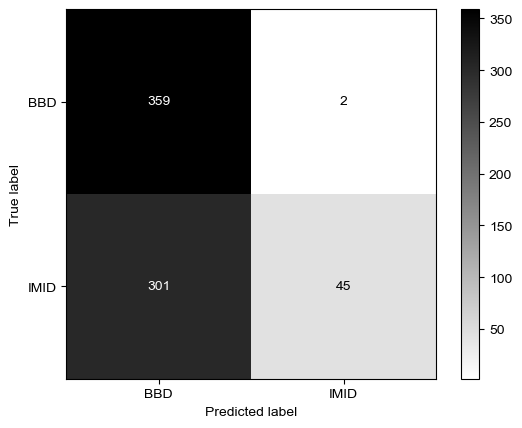

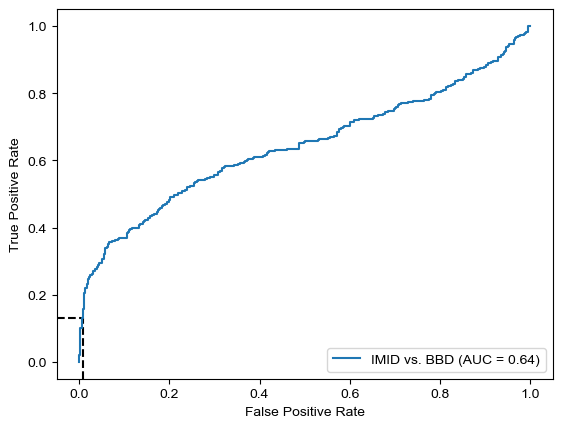

In [58]:
X_test, y_test = prep_data(data_all, 'IMID', 'BBD', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'IMID', 'BBD', threshold = 0.84)

### Random Forest

In [59]:
clf_rf = RandomForestClassifier(random_state=40)
np.mean(cross_val_score(clf_rf, X_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.8237835389830939

Untuned RF with no preprocessing performs similarly to logistic regression (but a little bit worse). Also very similar to current XGBoost models